### Library

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import streamlit as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Panggil & Check Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_kotor = pd.read_csv('combined_financial_data_idx.csv')
df_kotor.head()

,symbol,account,type,2020,2021,2022,2023
0,AALI,Accounts Payable,BS,7.702640e+11,1.026717e+12,1.224423e+12,8.420640e+11
1,AALI,Accounts Receivable,BS,7.658490e+11,4.581350e+11,8.487700e+11,6.744870e+11
2,AALI,Accumulated Depreciation,BS,-1.092095e+13,-1.213381e+13,-1.330375e+13,-1.443685e+13
3,AALI,Additional Paid In Capital,BS,3.878995e+12,3.878995e+12,3.878995e+12,3.878995e+12
4,AALI,Allowance For Doubtful Accounts Receivable,BS,-2.426100e+10,-2.454300e+10,-2.705700e+10,-2.651600e+10


In [5]:
df_kotor.shape

(89243, 7)

In [6]:
df_kotor.dtypes

symbol      object
account     object
type        object
2020       float64
2021       float64
2022       float64
2023       float64
dtype: object

In [7]:
df_kotor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89243 entries, 0 to 89242
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   symbol   89243 non-null  object 
 1   account  89243 non-null  object 
 2   type     89243 non-null  object 
 3   2020     83988 non-null  float64
 4   2021     84474 non-null  float64
 5   2022     83634 non-null  float64
 6   2023     69831 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.8+ MB


## Visualisasi

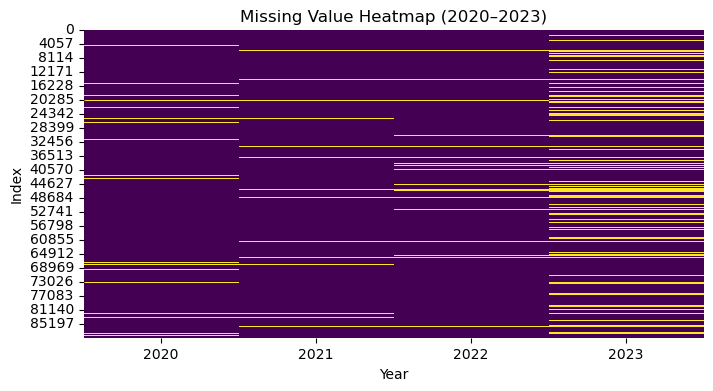

In [8]:
# Visualisasi Missing Values (HeatMap)
kolom_tahun = ['2020', '2021', '2022', '2023']

plt.figure(figsize=(8, 4))
sns.heatmap(df_kotor[kolom_tahun].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap (2020–2023)')
plt.xlabel('Year')
plt.ylabel('Index')
plt.show()

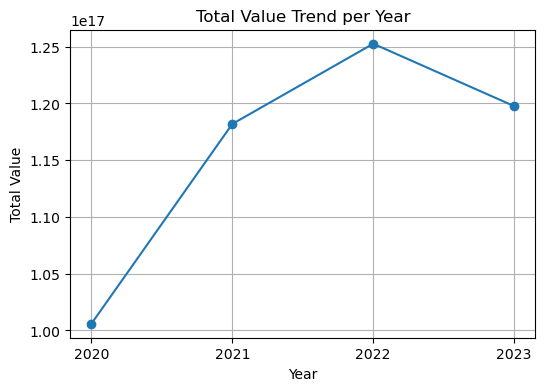

In [9]:
# Menghitung Tren Total per tahunnya
kolom_tahun = ['2020', '2021', '2022', '2023']
total_tahunan = df_kotor[kolom_tahun].sum()

plt.figure(figsize=(6,4))
plt.plot(total_tahunan.index, total_tahunan.values, marker='o')
plt.title('Total Value Trend per Year')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.grid(True)
plt.show()

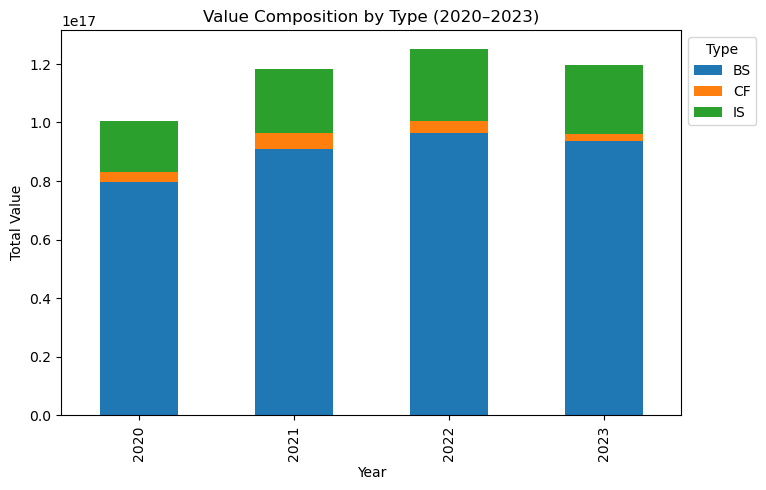

In [10]:
type_group = df_kotor.groupby('type')[kolom_tahun].sum()

type_group.T.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Value Composition by Type (2020–2023)')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.legend(title='Type', bbox_to_anchor=(1,1))
plt.show()

## **Preprocessing and Preparation** ##

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

kolom_angka = ['2020', '2021', '2022', '2023']

for kolom in kolom_angka:
    df_kotor[kolom] = pd.to_numeric(df_kotor[kolom], errors='coerce')

df_kotor[kolom_angka] = df_kotor[kolom_angka] / 1000

df_kotor.head()

,symbol,account,type,2020,2021,2022,2023
0,AALI,Accounts Payable,BS,770264000.00,1026717000.00,1224423000.00,842064000.00
1,AALI,Accounts Receivable,BS,765849000.00,458135000.00,848770000.00,674487000.00
2,AALI,Accumulated Depreciation,BS,-10920948000.00,-12133813000.00,-13303749000.00,-14436847000.00
3,AALI,Additional Paid In Capital,BS,3878995000.00,3878995000.00,3878995000.00,3878995000.00
4,AALI,Allowance For Doubtful Accounts Receivable,BS,-24261000.00,-24543000.00,-27057000.00,-26516000.00


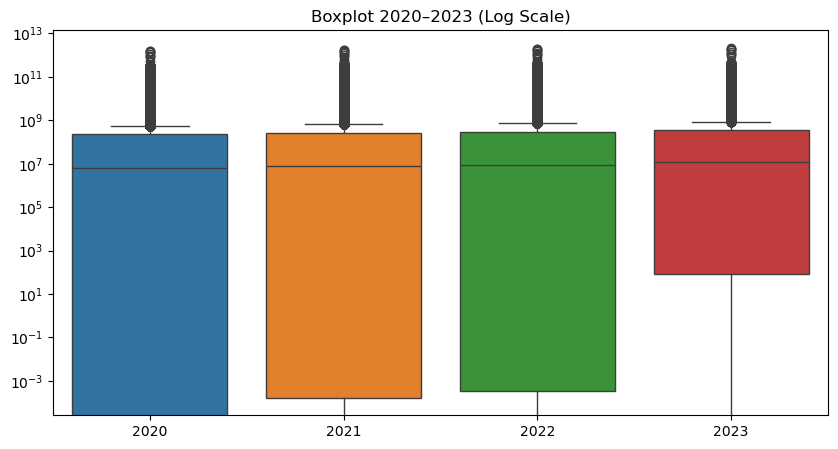

In [12]:
tahun = ['2020','2021','2022','2023']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_kotor[tahun])
plt.yscale('log')
plt.title("Boxplot 2020–2023 (Log Scale)")
plt.show()


### Data Cleaning

In [13]:
df_kotor_duplicate = df_kotor.duplicated().sum()
print(df_kotor_duplicate)

0


# EDA

### Missing Value

In [14]:
nulls = df_kotor.isnull().sum()
nulls_percentage = nulls[nulls != 0] / df_kotor.shape[0] * 100
print(round(nulls_percentage, 2))

2020    5.89
2021    5.34
2022    6.29
2023   21.75
dtype: float64


In [15]:
df_kotor[df_kotor.isna().any(axis=1)]


,symbol,account,type,2020,2021,2022,2023
10,AALI,Capital Expenditure Reported,CF,-28687000.00,NaN,NaN,NaN
48,AALI,Impairment Of Capital Assets,IS,50935000.00,-49898000.00,NaN,NaN
80,AALI,Net Other Financing Charges,CF,NaN,37785000.00,NaN,44612000.00
81,AALI,Net Other Investing Changes,CF,NaN,42794000.00,237226000.00,215362000.00
99,AALI,Other Non Current Liabilities,BS,246459000.00,401762000.00,216803000.00,NaN
...,...,...,...,...,...,...,...
89184,ZINC,Other Cash Paymentsfrom Operating Activities,CF,NaN,-121050196.38,NaN,-9039961.96
89185,ZINC,Other Cash Receiptsfrom Operating Activities,CF,16412161.93,NaN,19631796.70,NaN
89186,ZINC,Other Current Liabilities,BS,434035.05,638407.03,NaN,NaN
89188,ZINC,Other Non Current Liabilities,BS,204371.98,NaN,NaN,NaN


In [16]:
df=df_kotor.dropna()
df.shape

(65296, 7)

In [17]:
missing_values = df.isna().sum()
print("Missing Value Total: ")
missing_values

Missing Value Total: 


symbol     0
account    0
type       0
2020       0
2021       0
2022       0
2023       0
dtype: int64

### Cari Outlier

Outliers: 
2020: 13859
2021: 13157
2022: 13196
2023: 13301


C:\Users\sonny\AppData\Local\Temp\ipykernel_17744\1686417981.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[numeric_cols].dropna(), labels=numeric_cols, vert=True)


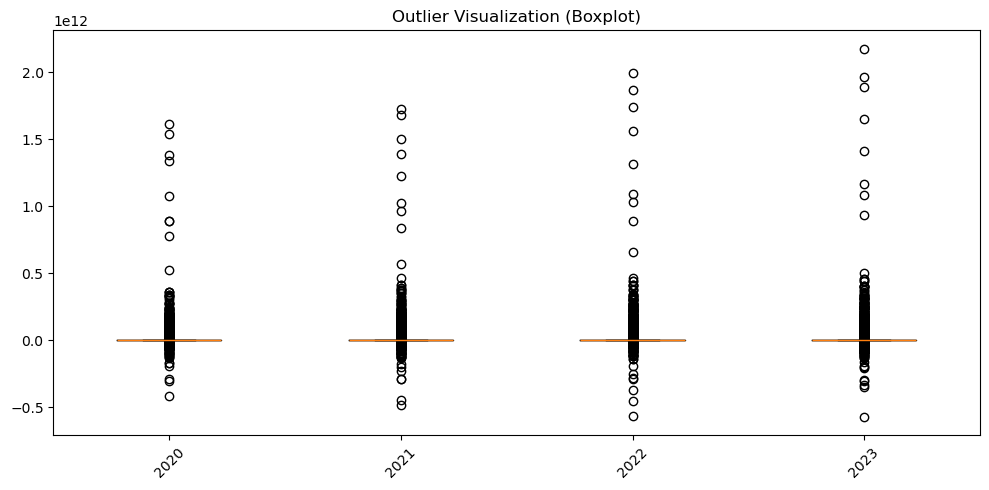

In [18]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier_counts[col] = ((df[col] < lower) | (df[col] > upper)).sum()

print("Outliers: ")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

plt.figure(figsize=(10,5))
plt.boxplot(df[numeric_cols].dropna(), labels=numeric_cols, vert=True)
plt.title("Outlier Visualization (Boxplot)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Handling Outliers using IQR Capping
- Column 2020: Beginning=13859, After Handling=0
- Column 2021: Beginning=13157, After Handling=0
- Column 2022: Beginning=13196, After Handling=0
- Column 2023: Beginning=13301, After Handling=0


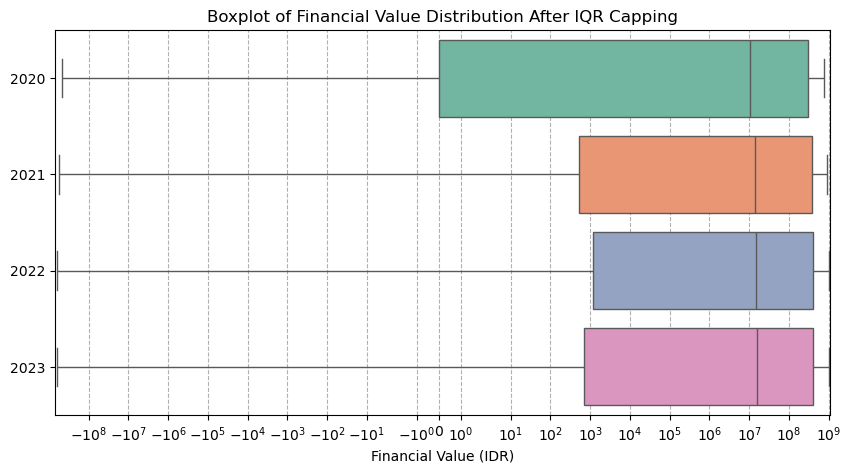

In [19]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
print("Handling Outliers using IQR Capping")
df_handled = df.copy()

for col in numeric_cols:
    Q1 = df_handled[col].quantile(0.25)
    Q3 = df_handled[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_sblm = ((df_handled[col] < lower) | (df_handled[col] > upper)).sum()

    df_handled[col] = np.where(df_handled[col] < lower, lower, df_handled[col])
    df_handled[col] = np.where(df_handled[col] > upper, upper, df_handled[col])

    outliers_stlh = ((df_handled[col] < lower) | (df_handled[col] > upper)).sum()
    print(f"- Column {col}: Beginning={ outliers_sblm}, After Handling={outliers_stlh}")

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_handled[numeric_cols], orient="h", palette="Set2")
plt.title('Boxplot of Financial Value Distribution After IQR Capping')
plt.xlabel('Financial Value (IDR)')
plt.xscale('symlog')
plt.grid(axis='x', linestyle='--')
plt.show()

### Correlation

Correlation Matrix: 
      2020  2021  2022  2023
2020  1.00  0.98  0.98  0.98
2021  0.98  1.00  0.99  0.97
2022  0.98  0.99  1.00  0.99
2023  0.98  0.97  0.99  1.00


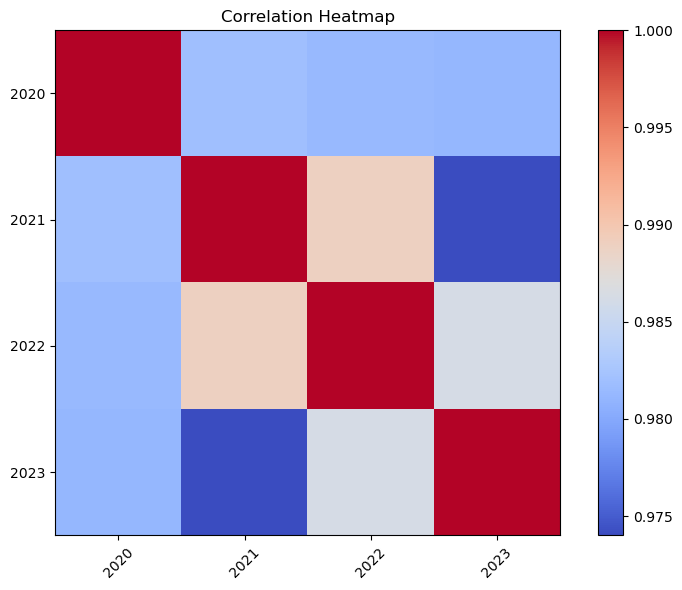

In [20]:
corr = df[numeric_cols].corr()
print("Correlation Matrix: ")
print(corr)

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.title("Correlation Heatmap")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()

# Machine Learning

In [21]:
X = df_handled[['2020','2021','2022']].astype(float).values
y = df_handled['2023'].astype(float).values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Clustering K-Means

In [23]:
# memilih 7 symbol perusahaan terlebih dahulu
selected_symbols = ["aali", "aces", "blta", "jarr", "mlbi", "mcas", "pcar"]
df_kmeans = df[df["symbol"].str.lower().isin(selected_symbols)]

In [24]:
# memilih 5 akun untuk dipakai dalam clustering k-means dalam prediksi
selected_accounts = [
    "Net Income",
    "Total Liabilities Net Minority Interest",
    "Total Assets",
    "Total Debt",
    "Total Equity Gross Minority Interest"
]
df_kmeans = df_kmeans[df_kmeans["account"].isin(selected_accounts)]

In [25]:
df_kmeans

,symbol,account,type,2020,2021,2022,2023
70,AALI,Net Income,IS,833090000.00,1971365000.00,1726607000.00,1055897000.00
131,AALI,Total Assets,BS,27781231000.00,30399906000.00,29249340000.00,28846243000.00
133,AALI,Total Debt,BS,5623933000.00,5696405000.00,4053767000.00,4005052000.00
134,AALI,Total Equity Gross Minority Interest,BS,19247794000.00,21171173000.00,22243221000.00,22566006000.00
136,AALI,Total Liabilities Net Minority Interest,BS,8533437000.00,9228733000.00,7006119000.00,6280237000.00
662,ACES,Net Income,IS,733195452.45,690770530.34,664342863.39,763507487.62
732,ACES,Total Assets,BS,7216725069.89,7171138470.21,7249254612.05,7753269368.75
734,ACES,Total Debt,BS,833227802.42,834356075.39,708253731.98,875136365.86
735,ACES,Total Equity Gross Minority Interest,BS,5343597852.00,5578980277.55,5933988630.61,6186397789.09
737,ACES,Total Liabilities Net Minority Interest,BS,1873127217.90,1592158192.66,1315265981.44,1566871579.66


In [26]:
df_pivot = df_kmeans.pivot_table(
    index="symbol", # tiap perusahaan jadi baris
    columns="account", # tiap akun jadi kolom
    values=["2020", "2021", "2022", "2023"], # nilai masing masing tahun
)

# hilangkan multi-index pada kolom biar rapi
df_pivot.columns = [f"{year}_{acc}" for year, acc in df_pivot.columns]

# reset index jadi kolom "symbol"
df_pivot = df_pivot.reset_index()

feature_cols = [col for col in df_pivot.columns if col != "symbol"]
X = df_pivot[feature_cols]

Visualisasi 1: Heatmap perbandingan semua

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
df_pivot["cluster"] = kmeans.fit_predict(X_scaled)

C:\Users\sonny\anaconda3\envs\00000107765_SonnyFerdinand\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [28]:
df_pivot

,symbol,2020_Net Income,2020_Total Assets,2020_Total Debt,2020_Total Equity Gross Minority Interest,2020_Total Liabilities Net Minority Interest,2021_Net Income,2021_Total Assets,2021_Total Debt,2021_Total Equity Gross Minority Interest,2021_Total Liabilities Net Minority Interest,2022_Net Income,2022_Total Assets,2022_Total Debt,2022_Total Equity Gross Minority Interest,2022_Total Liabilities Net Minority Interest,2023_Net Income,2023_Total Assets,2023_Total Debt,2023_Total Equity Gross Minority Interest,2023_Total Liabilities Net Minority Interest,cluster
0,AALI,833090000.00,27781231000.00,5623933000.00,19247794000.00,8533437000.00,1971365000.00,30399906000.00,5696405000.00,21171173000.00,9228733000.00,1726607000.00,29249340000.00,4053767000.00,22243221000.00,7006119000.00,1055897000.00,28846243000.00,4005052000.00,22566006000.00,6280237000.00,1
1,ACES,733195452.45,7216725069.89,833227802.42,5343597852.00,1873127217.90,690770530.34,7171138470.21,834356075.39,5578980277.55,1592158192.66,664342863.39,7249254612.05,708253731.98,5933988630.61,1315265981.44,763507487.62,7753269368.75,875136365.86,6186397789.09,1566871579.66,0
2,BLTA,-817.14,66073.09,18998.18,27914.95,38158.14,5895.39,73922.11,16785.72,32683.89,41238.22,9495.06,77718.70,15077.38,39959.50,37759.20,15616.88,93000.23,15962.95,57620.38,35379.85,0
3,JARR,-23157492.19,1100890257.58,397256781.79,16510901.01,1084379356.58,15869994.59,2407028987.20,1239178587.01,750257986.33,1656771000.88,41681880.21,3489310229.05,1446612914.33,1274264114.96,2215046114.09,77266308.10,3652686220.01,1924831437.94,1441571515.76,2211114704.24,0
4,MCAS,25638796.17,1835183217.11,173240847.22,1331916693.55,503266523.55,63078307.69,2134534261.34,151699436.22,1517016987.53,617517273.81,24813647.91,1911368459.55,229025026.97,1294390152.94,616978306.61,540846.92,1989974666.24,368418672.24,1169942777.16,820031889.08,0
5,MLBI,285666000.00,2907425000.00,325991000.00,1433406000.00,1474019000.00,665682000.00,2922017000.00,438754000.00,1099157000.00,1822860000.00,924767000.00,3374502000.00,441096000.00,1073275000.00,2301227000.00,1066178000.00,3407442000.00,389080000.00,1391455000.00,2015987000.00,0
6,PCAR,-15948619.12,103351122.21,15488324.01,63670233.32,39680888.89,1278343.38,100382982.90,16275190.90,56273081.41,44109901.49,4932611.28,102809758.19,14011284.73,61178353.93,41631404.26,9203977.25,101565767.10,18890706.69,66832180.63,34733586.47,0


In [29]:
numeric_cols = df_pivot.columns.difference(['symbol', 'cluster'])

In [30]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_pivot[numeric_cols])

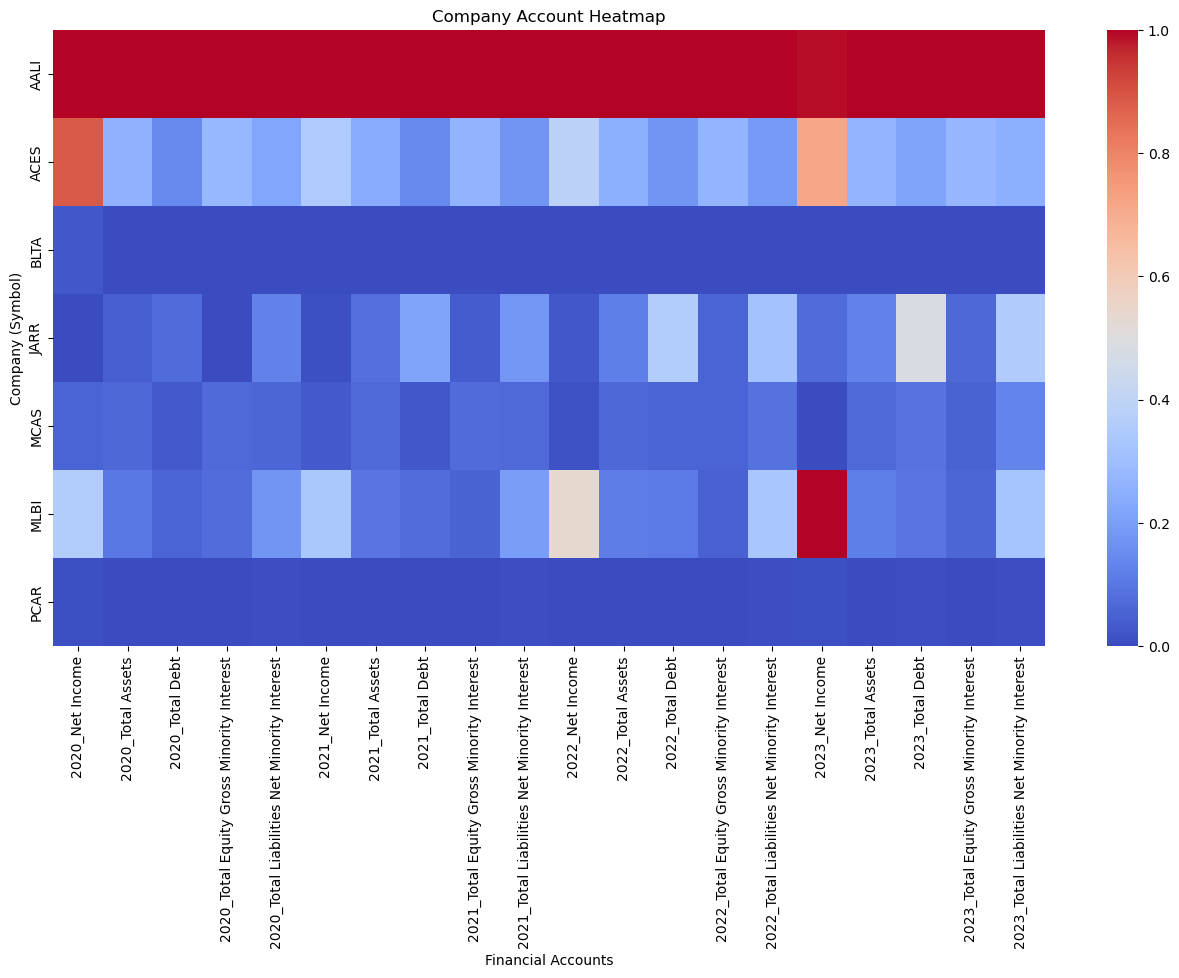

In [31]:
df_heatmap = pd.DataFrame(scaled_values,
                          index=df_pivot['symbol'],
                          columns=numeric_cols)

plt.figure(figsize=(16, 8))
sns.heatmap(df_heatmap, annot=False, cmap="coolwarm")
plt.title("Company Account Heatmap")
plt.xlabel("Financial Accounts")
plt.ylabel("Company (Symbol)")
plt.show()

Visualisasi 2: Scatterplot perbandingan income dan total assets di 2023

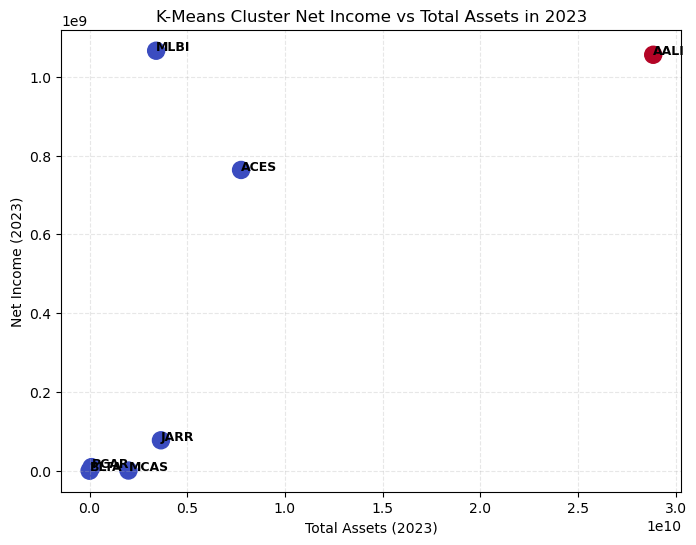

In [32]:
plt.figure(figsize=(8,6))

plt.scatter(
    df_pivot["2023_Total Assets"],
    df_pivot["2023_Net Income"],
    c=df_pivot["cluster"],
    cmap="coolwarm",
    s=150
)

for i, row in df_pivot.iterrows():
    plt.text(row["2023_Total Assets"], row["2023_Net Income"],
             row["symbol"], fontsize=9, fontweight="bold")

plt.xlabel("Total Assets (2023)")
plt.ylabel("Net Income (2023)")
plt.title("K-Means Cluster Net Income vs Total Assets in 2023")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


### Regression - Random Forest

In [33]:
lr = LinearRegression()
# Initialize a new StandardScaler for regression
regression_scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = regression_scaler.fit_transform(X_train)
X_test_scaled = regression_scaler.transform(X_test)

# Linear Regression Model Initiation
# Train directly on original y_train values, as they can be negative and are not suitable for log1p transformation
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [34]:
# Random Forest Model Initiation
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

In [68]:
joblib.dump(rf, 'financial_model.pkl')

['financial_model.pkl']

In [71]:
st.set_page_config(page_title="Business Finance Analytics", layout="centered")

st.title("📈 Business Finance Predictor")
st.write("Aplikasi prediksi performa keuangan (Tahun 2023) berdasarkan data historis 3 tahun sebelumnya menggunakan Random Forest.")

@st.cache_resource
def load_model():
    try:
        model = joblib.load('financial_model.pkl')
        return model
    except FileNotFoundError:
        st.error("File 'financial_model.pkl' tidak ditemukan. Harap jalankan train_model.py terlebih dahulu.")
        return None

model = load_model()

st.sidebar.header("Input Data Keuangan")
st.sidebar.info("Masukkan nilai dalam format angka penuh (contoh: 1000000000)")

val_2020 = st.sidebar.number_input("Nilai Tahun 2020", value=0.0)
val_2021 = st.sidebar.number_input("Nilai Tahun 2021", value=0.0)
val_2022 = st.sidebar.number_input("Nilai Tahun 2022", value=0.0)

if st.button("Prediksi Tahun 2023"):
    if model is not None:
        input_data = pd.DataFrame([[val_2020, val_2021, val_2022]], columns=['2020', '2021', '2022'])
        prediction = model.predict(input_data)[0]
        st.success(f"Prediksi Nilai Tahun 2023:")
        st.metric(label="Projected Value", value=f"Rp {prediction:,.2f}")
        chart_data = pd.DataFrame({
            'Tahun': ['2020', '2021', '2022', '2023 (Prediksi)'],
            'Nilai': [val_2020, val_2021, val_2022, prediction]
        })
        st.line_chart(chart_data, x='Tahun', y='Nilai')
        
    else:
        st.error("Model belum dimuat.")

st.markdown("---")
st.caption("Dikembangkan oleh Kelompok 8 - Business Finance Analytics")

2025-12-05 16:05:07.494 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-05 16:05:07.495 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-05 16:05:07.608 
  command:

    streamlit run C:\Users\sonny\anaconda3\envs\00000107765_SonnyFerdinand\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-05 16:05:07.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-05 16:05:07.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-05 16:05:07.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-05 16:05:07.611 Thread 'MainThread': missing ScriptRunContext! This 

DeltaGenerator()

In [73]:
joblib.dump(model, "app.py")

['app.py']

In [35]:
# Report the evaluation of the model To Compare how good the model is
def eval_reg(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [36]:
lr_rmse, lr_mae, lr_r2 = eval_reg(y_test, y_pred_lr)
rf_rmse, rf_mae, rf_r2 = eval_reg(y_test, y_pred_rf)

# Linear Regression Model Evaluate
print("Linear Regression:")
print("RMSE:", lr_rmse)
print("MAE:", lr_mae)
print("R²:", lr_r2)
print("")

# Random Forest Model Evaluate
print("Random Forest:")
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)
print("R²:", rf_r2)

Linear Regression:
RMSE: 155552793.34907606
MAE: 64633416.13647155
R²: 0.870459711925757

Random Forest:
RMSE: 144685969.29476961
MAE: 55318218.51117002
R²: 0.8879267242524779


In [37]:
X_2024 = df_handled[['2021','2022','2023']].astype(float).values
# Create and fit a new scaler specifically for X_2024
X_2024_scaler = StandardScaler()
X_2024_scaled = regression_scaler.fit_transform(X_2024)

In [38]:

pred_2024_lr = lr.predict(X_2024_scaled)
pred_2024_rf = rf.predict(X_2024_scaled)

In [39]:
output_df = df_handled[['symbol','account','type','2020','2021','2022','2023']].copy().reset_index(drop=True)
output_df['pred_2024_lr'] = pred_2024_lr
output_df['pred_2024_rf'] = pred_2024_rf

In [40]:
output_df.head(20)

,symbol,account,type,2020,2021,2022,2023,pred_2024_lr,pred_2024_rf
0,AALI,Accounts Payable,BS,754310625.00,930075852.45,1008193965.06,842064000.00,871861598.69,763722699.23
1,AALI,Accounts Receivable,BS,754310625.00,458135000.00,848770000.00,674487000.00,647264283.71,655101324.14
2,AALI,Accumulated Depreciation,BS,-452586375.00,-558044668.09,-604914440.43,-607970019.11,-575624960.66,-574495153.59
3,AALI,Additional Paid In Capital,BS,754310625.00,930075852.45,1008193965.06,1013285211.47,980964684.85,970984445.52
4,AALI,Allowance For Doubtful Accounts Receivable,BS,-24261000.00,-24543000.00,-27057000.00,-26516000.00,-17496827.51,-29586860.22
5,AALI,Basic Average Shares,IS,1924688.33,1924688.33,1924688.33,1924688.33,9976833.29,2061638.18
6,AALI,Basic EPS,IS,0.43,1.02,0.90,0.55,8095442.82,2061638.18
7,AALI,Beginning Cash Position,CF,383366000.00,930075852.45,1008193965.06,1013285211.47,980964684.85,970984445.52
8,AALI,Buildings And Improvements,BS,754310625.00,930075852.45,1008193965.06,1013285211.47,980964684.85,970984445.52
9,AALI,Capital Expenditure,CF,-452586375.00,-558044668.09,-604914440.43,-607970019.11,-575624960.66,-574495153.59


In [41]:
print("Training rows:", len(df_handled))
print("Linear Regression:", lr_rmse, lr_mae, lr_r2)
print("Random Forest:", rf_rmse, rf_mae, rf_r2)

Training rows: 65296
Linear Regression: 155552793.34907606 64633416.13647155 0.870459711925757
Random Forest: 144685969.29476961 55318218.51117002 0.8879267242524779


## Visualization ##


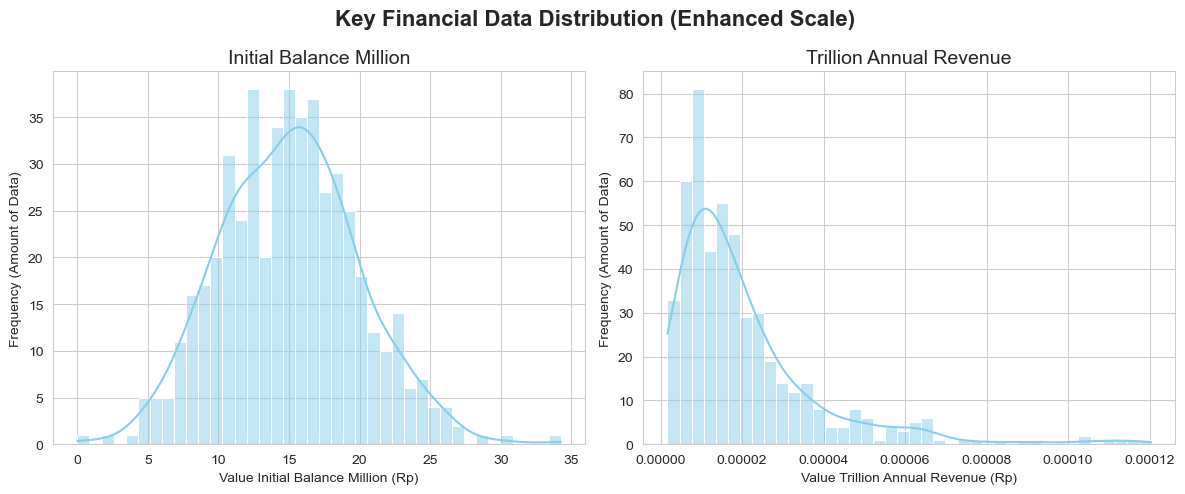

In [42]:
np.random.seed(42)
data_simulated = {
    'Beginning_balance': np.random.normal(loc=15000000, scale=5000000, size=500),
    'Annual_Income': np.random.lognormal(mean=16.5, sigma=0.8, size=500),
}
df_simulated_financial_data = pd.DataFrame(data_simulated)
df_simulated_financial_data = df_simulated_financial_data.apply(lambda x: np.maximum(1000, x))

# 1. Initial Balance divided by 1 Million (so that 15,000,000 becomes 15)
df_simulated_financial_data['Initial_Balance_Million'] = df_simulated_financial_data['Beginning_balance'] / 1_000_000
# 2. Annual Income divided by 1 Trillion (1,000,000,000,000)
df_simulated_financial_data['Trillion_Annual_Revenue'] = df_simulated_financial_data['Annual_Income'] / 1_000_000_000_000
# ----------------------------------------------------

selected_numeric_cols = ['Initial_Balance_Million', 'Trillion_Annual_Revenue']

sns.set_style('whitegrid')
plt.figure(figsize=(12, 5))

for i, col in enumerate(selected_numeric_cols):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df_simulated_financial_data[col], kde=True, bins=40, color='skyblue')

    # Penyesuaian Label Sumbu X dan Judul
    if 'Juta' in col:
        label_unit = '(Million Rupiah)'
        title_text = 'Beginning balance'
    elif 'Triliun' in col:
        label_unit = '(Trillions of Rupiah)'
        title_text = 'Annual Income'
    else:
        label_unit = '(Rp)'
        title_text = col.replace("_", " ").title()

    plt.title(title_text, fontsize=14)
    plt.xlabel(f'Value {title_text} {label_unit}')
    plt.ylabel('Frequency (Amount of Data)')

plt.suptitle('Key Financial Data Distribution (Enhanced Scale)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

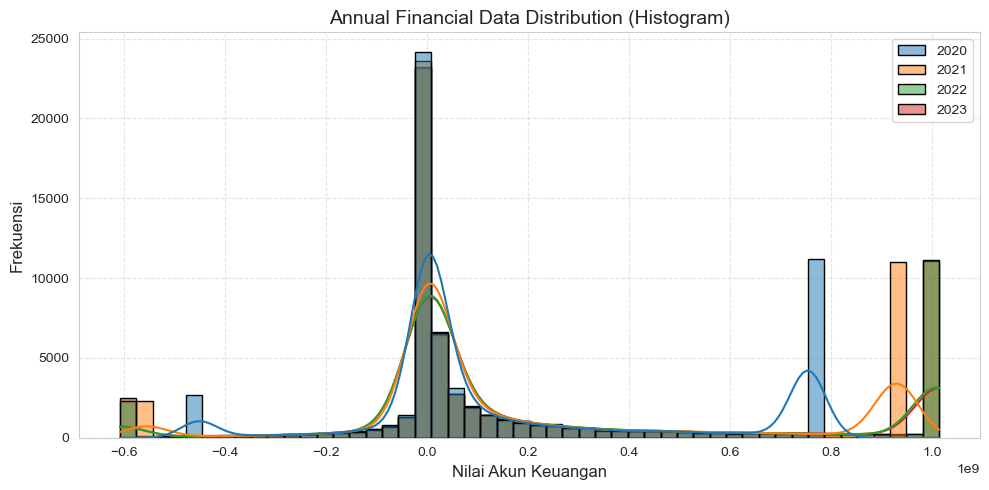

In [43]:
plt.figure(figsize=(10, 5))
numeric_cols = df_handled.select_dtypes(include=["float64", "int64"]).columns.tolist()

sns.histplot(df_handled[numeric_cols], kde=True, bins=50, color='skyblue', edgecolor='black')
plt.title('Annual Financial Data Distribution (Histogram)', fontsize=14)
plt.xlabel('Nilai Akun Keuangan', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True, alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

In [44]:
feature_names = ['2020','2021','2022']
X = df_handled[feature_names]
y = df_handled['2023']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [46]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [47]:
model_rf = RandomForestRegressor(
    n_estimators=15,
    max_depth=6,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
model_rf.fit(X_train, y_train)

,n_estimators,15
,criterion,'squared_error'
,max_depth,6
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
model_rf = RandomForestRegressor(
    n_estimators=20,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

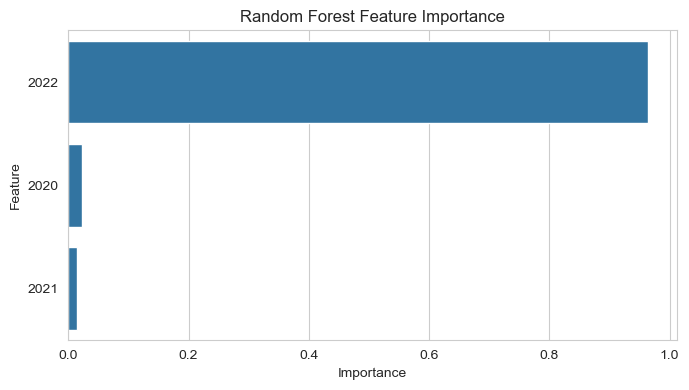

In [49]:
importance = model_rf.feature_importances_

fi = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(data=fi, x='Importance', y='Feature')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

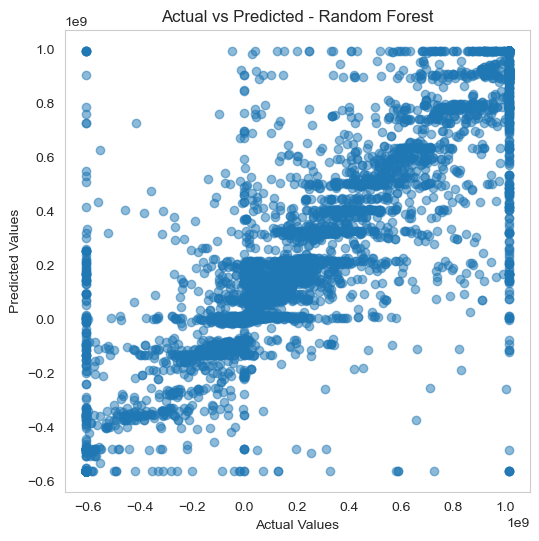

In [50]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted - Random Forest")
plt.grid()
plt.show()

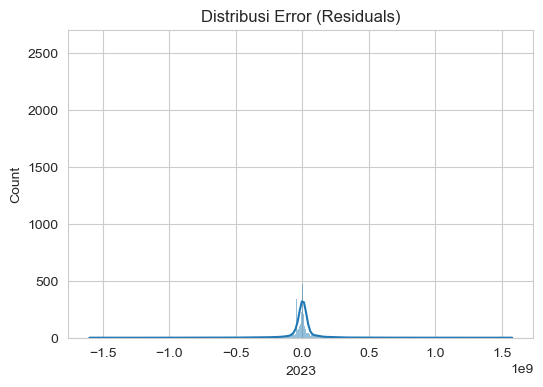

In [51]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Distribusi Error (Residuals)")
plt.show()

In [52]:
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 60011534.5534035
RMSE: 151742197.800092
R²: 0.8767287017800055


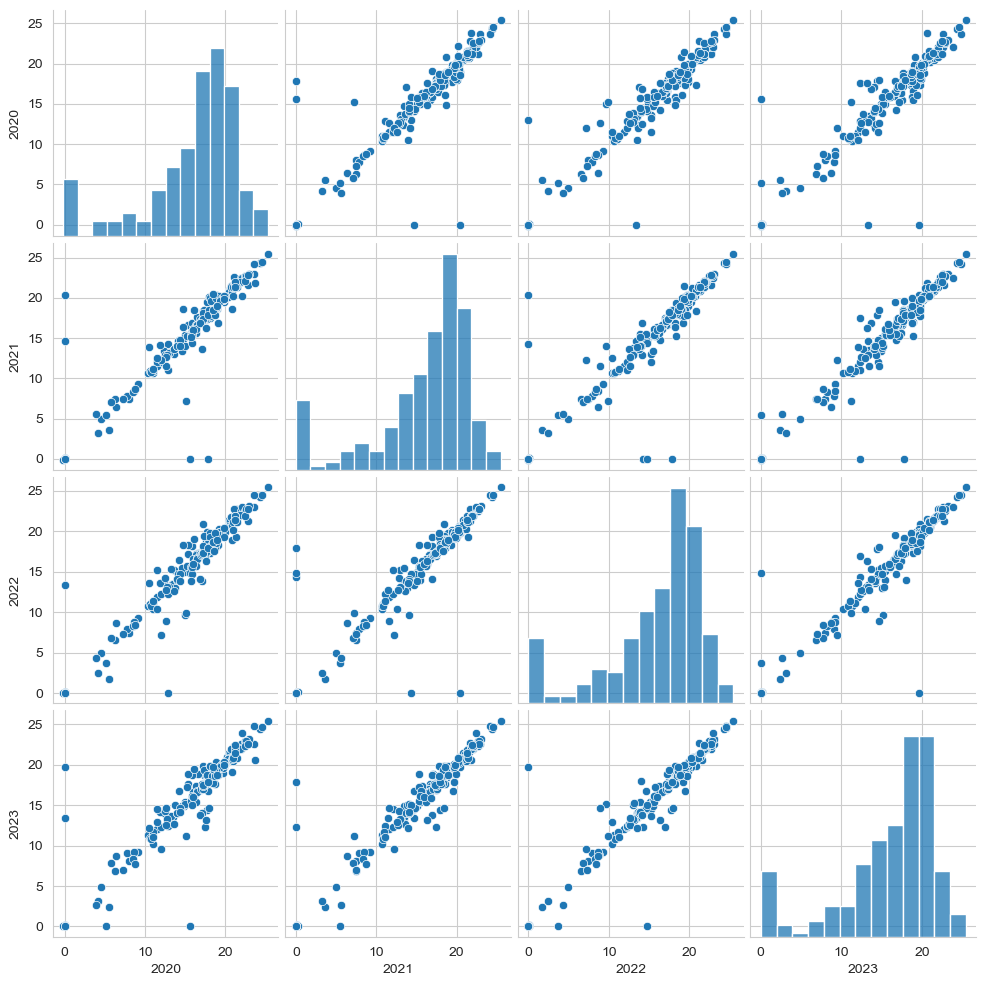

In [53]:
# Pairplot / Scatter Matrix (Korelasi antar tahun)
years = ['2020','2021','2022','2023'] # Ensure years list is available
df_log = df[years].apply(np.log1p) # Create df_log by applying log1p transformation to year columns of df
df_sample = df_log.sample(300, random_state=42) # Added random_state for reproducibility
sns.pairplot(df_sample)
plt.show()

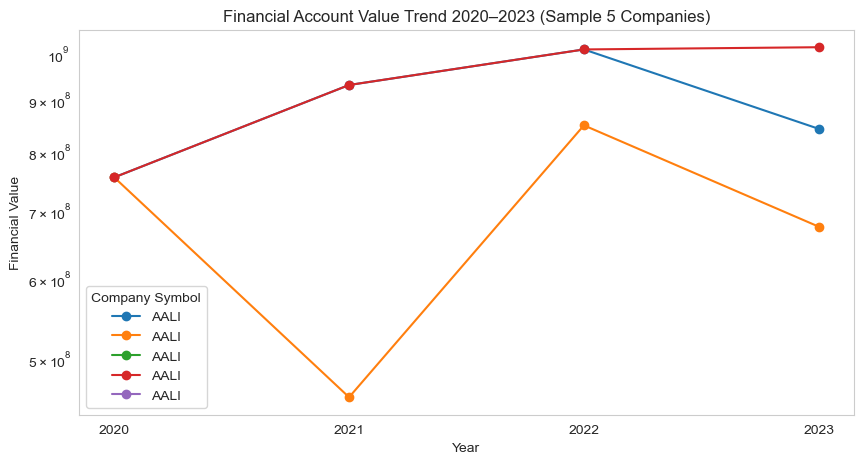


Company Symbols displayed in the plot:
['AALI', 'AALI', 'AALI', 'AALI', 'AALI']


In [54]:
# Line Plot Financial Account Trend
sample = df_handled.head(5) # The first 5 rows of the handled data

plt.figure(figsize=(10, 5))
for idx, row in sample.iterrows():
    # Use the company symbol (row['symbol']) as the label for the legend
    plt.plot(
        ['2020', '2021', '2022', '2023'],
        row[['2020', '2021', '2022', '2023']],
        marker='o',
        label=row['symbol']
    )

plt.title("Financial Account Value Trend 2020–2023 (Sample 5 Companies)")
plt.xlabel("Year")
plt.ylabel("Financial Value")
plt.yscale("log")
plt.grid()
plt.legend(title='Company Symbol')
plt.show()

# To clearly see the company symbols used:
company_symbols = sample['symbol'].tolist()
print("\nCompany Symbols displayed in the plot:")
print(company_symbols)

C:\Users\sonny\anaconda3\envs\00000107765_SonnyFerdinand\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sonny\anaconda3\envs\00000107765_SonnyFerdinand\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


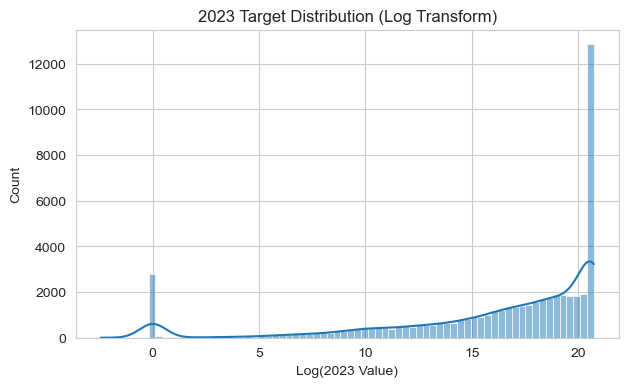

In [55]:
# Distribusi Target
plt.figure(figsize=(7,4))
sns.histplot(np.log1p(df_handled['2023']), kde=True)
plt.title("2023 Target Distribution (Log Transform)")
plt.xlabel("Log(2023 Value)")
plt.show()

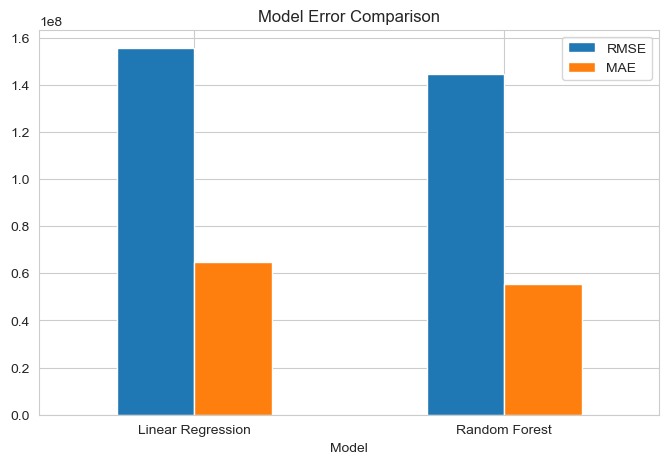

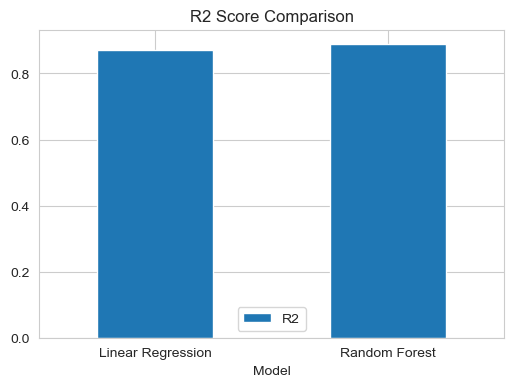

In [56]:
# Perbandingan Model ML (LR vs RF)
model_scores = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae],
    'R2': [lr_r2, rf_r2]
})

model_scores.plot(x='Model', y=['RMSE','MAE'], kind='bar', figsize=(8,5))
plt.title("Model Error Comparison")
plt.xticks(rotation=0)
plt.show()

model_scores.plot(x='Model', y='R2', kind='bar', figsize=(6,4))
plt.title("R2 Score Comparison")
plt.xticks(rotation=0)
plt.show()

## Time Series And Forecasting

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65296 entries, 0 to 89242
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   symbol   65296 non-null  object 
 1   account  65296 non-null  object 
 2   type     65296 non-null  object 
 3   2020     65296 non-null  float64
 4   2021     65296 non-null  float64
 5   2022     65296 non-null  float64
 6   2023     65296 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.0+ MB


In [58]:
df_series = df_kotor.melt(
    id_vars=['symbol', 'account', 'type'],
    value_vars=['2020', '2021', '2022', '2023'],
    var_name='year',
    value_name='value'
)

In [59]:
df_series['year'] = pd.to_datetime(df_series['year'], format='%Y')

In [60]:
df_time = df_series.set_index('year').sort_index()

<Axes: xlabel='year'>

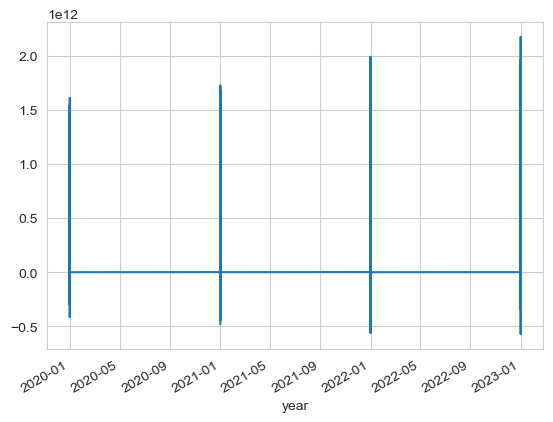

In [61]:
df_time['value'].plot()

In [62]:
df_time['value'] = df_time['value'].fillna(df_time['value'].mean())

In [63]:
df_timeseries = df_series[df_series['symbol'] == 'BBRI']
df_timeseries = df_timeseries.set_index('year').sort_index()
df_timeseries

,symbol,account,type,value
year,,,,
2020-01-01,BBRI,Accounts Payable,BS,1765500000.00
2020-01-01,BBRI,Accumulated Depreciation,BS,-17178222000.00
2020-01-01,BBRI,Additional Paid In Capital,BS,3411813000.00
2020-01-01,BBRI,Available For Sale Securities,BS,298790894000.00
2020-01-01,BBRI,Basic Average Shares,IS,122564847.24
...,...,...,...,...
2023-01-01,BBRI,Total Unusual Items,IS,16460917000.00
2023-01-01,BBRI,Total Unusual Items Excluding Goodwill,IS,16460917000.00
2023-01-01,BBRI,Treasury Shares Number,BS,768144.90


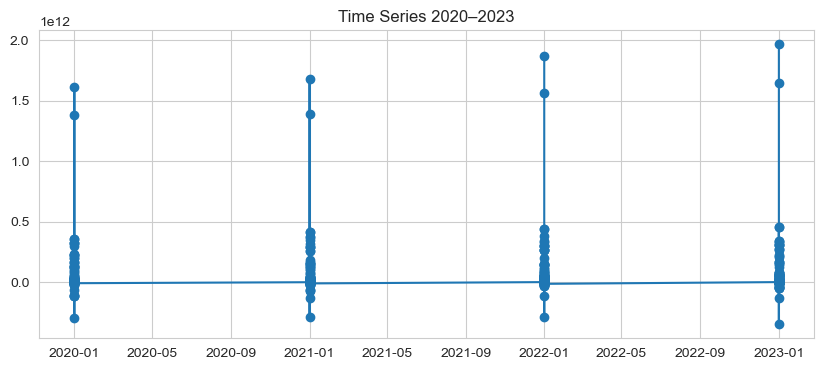

In [64]:
plt.figure(figsize=(10,4))
plt.plot(df_timeseries['value'], marker='o')
plt.title("Time Series 2020–2023")
plt.show()

In [65]:
# Forecasting
train = df_timeseries.iloc[:-1]
test = df_timeseries.iloc[-1:]

mean_value = train['value'].mean()
test['Forecast'] = mean_value
test

C:\Users\sonny\AppData\Local\Temp\ipykernel_17744\1542398472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = mean_value


,symbol,account,type,value,Forecast
year,,,,,
2023-01-01,BBRI,Write Off,IS,-16335730000.00,75782208482.28


Perbandingan model

In [66]:
lr_rmse = 155552793.34907612    # Linear Regression: Semakin kecil, semakin baik
lr_r2 = 0.8704597119257569      # Linear Regression: Semakin dekat ke 1, semakin baik

rf_rmse = 144685969.29476961    # Random Forest: Semakin kecil, semakin baik
rf_r2 = 0.8879267242524779      # Random Forest: Semakin dekat ke 1, semakin baik
# =======================================================

# 1. Membuat Tabel Perbandingan
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regressor'],
    'RMSE (Error)': [lr_rmse, rf_rmse],
    'R2 Score (Kesesuaian)': [lr_r2, rf_r2]
})

# Urutkan berdasarkan R2 Score (yang terbaik di atas)
comparison_df = comparison_df.sort_values(by='R2 Score (Kesesuaian)', ascending=False).reset_index(drop=True)

print("Hasil Perbandingan Model")
print(comparison_df.to_markdown(index=False))

print("\n" + "---" * 15 + "\n")

# 2. Menentukan Model Terbaik
best_model = comparison_df.iloc[0]

print(f"Model Terbaik adalah: {best_model['Model']}")

# 3. Alasan Kenapa Model Itu Terbaik
print("Alasan Utama:")
print(f"R^2 Score Tertinggi: Model ini memiliki R^2 Score sebesar {best_model['R2 Score (Kesesuaian)']:.4f} (Paling mendekati 1).")
print("    > Ini berarti model ini paling baik dalam menjelaskan data.")
print(f"RMSE Terendah: Model ini juga memiliki kesalahan prediksi rata-rata (RMSE) yang paling kecil, yaitu {best_model['RMSE (Error)']:.2f}.")
print("    > Ini berarti rata-rata kesalahan prediksi model ini lebih kecil, membuatnya lebih akurat.")
print(f"Kesimpulan: Karena model {best_model['Model']} memiliki kemampuan penjelasan data (R^2) yang lebih tinggi dan tingkat kesalahan (RMSE) yang lebih rendah, model ini adalah pilihan terbaik untuk prediksi.")

# 4. Visualisasi (Tambahan)
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2 Score (Kesesuaian)', data=comparison_df)
plt.title('Perbandingan Kualitas Prediksi (R^2 Score)')
plt.ylabel('R2 Score')
plt.ylim(comparison_df['R2 Score (Kesesuaian)'].min() - 0.05, 1.0) # Agar plot terlihat jelas
plt.show()

Hasil Perbandingan Model


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.